In [21]:
import os, sys
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.helpers import num_params#, get_masks
from include.decoder_conv import init_convdecoder
from include.fit import fit
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)

In [3]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', 'est', 'dc']
    
    fig = plt.figure(figsize=(10,10))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx])
        ax.axis('off')

In [4]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

print(len(files))

164


##### data format
- 'kspace': Nx x Ny x Nz x # echos x # coils
- 'maps': Nx x Ny x Nz x # coils x # maps
- 'target': Nx x Ny x Nz x # echos x # maps

take kspace, run on one echo. what to do w num coils? recon all, then rss at end

### load data, make mask

In [84]:
# fn = files[0]
fn = files[1]
f = h5py.File(path + fn, 'r')

ksp = torch.from_numpy(f['kspace'][()])
targ = torch.from_numpy(f['target'][()])
# ksp = torch.from_numpy(np.load('ksp_3d_samp.npy'))

ksp_vol = ksp[:,:,:,0,:].permute(3,0,1,2) # get echo1, reshape to be (nc, kx, ky, kz)
ksp_vol.shape

torch.Size([8, 512, 512, 160])

In [99]:
# mask = poisson(img_shape=(512, 160), accel=4)
# mask = abs(mask)
# np.save('mask_3d.npy', mask)
mask = torch.from_numpy(np.load('mask_3d.npy'))#.astype('float32'))
mask = abs(mask).type(torch.uint8)
mask.shape

torch.Size([512, 160])

### force central `CxC` pixels in mask to be 1 

In [100]:
idx_y, idx_z = mask.shape[0] // 2, mask.shape[1] // 2

C=32
mask[idx_y-C:idx_y+C, idx_z-C:idx_z+C] = 1

### get central slice in kx of volumes
because dd+ requires a 2d recon, and we're undersampling in ky, kz

In [101]:
idx_kx = ksp_vol.shape[1] // 2
ksp_orig = ksp_vol[:, idx_kx, :, :]

### initialize network

network has same num_params as original network w lone difference of 32 = 2 * n_c output channels instead of 30. hence as written now, network is agnostic to number of pixels in a slice, e.g. 512x512 would have same num_params as 512x160 -- is this right?

also note -- using fully-sampled k-space i.e. `ksp_orig` to initialize the network -- might be cheating?

In [102]:
# original: slice_ksp (nc,x,y), mask (kx,ky). now ksp_orig (nc,ky,kz), mask (ky,kz)
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

# from utils.helpers import num_params
# params = [p.shape for p in net.parameters()]
# params

### apply mask
currently a modified version of the function call `ksp_masked, img_masked = get_masked_measurements(vol_ksp, mask_)` which has a bunch of data shape conversion nonsense

In [103]:
ksp_masked = ksp_orig_ * mask
img_masked = ifft_2d(ksp_masked)

ksp_orig.shape, ksp_masked.shape, img_masked.shape

(torch.Size([8, 512, 160]),
 torch.Size([8, 512, 160]),
 torch.Size([8, 512, 160]))

### TODO: make new data format work for fastmri

### run network

lesson: doing .type(dtype) will change complex tensor to float when dtype=torch.cuda.float

In [104]:
# want img_masked, ksp_masked to be complex tensors shape [nc,ky,kz]
net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=100)

### get net output, apply dc step

note: big difference in `im_est` and/or `im_dc` output when using `ksp_masked` created by using `ksp_orig_` (scaled): gives much sharper output compared to using `ksp_orig` (non-scaled): gives blurrier output

In [126]:
img_out = net(net_input.type(dtype))[0]

# make complex tensor [nc,x,y] from [2*nc,x,y]
img_out = reshape_adj_channels_to_complex_vals(img_out)

ksp_est = fft_2d(img_out)

# apply dc step
ksp_dc = torch.where(mask, ksp_masked, ksp_est) 

### create images from k-space

In [127]:
img_est = root_sum_squares(ifft_2d(ksp_est)).detach()

img_dc = root_sum_squares(ifft_2d(ksp_dc)).detach()

img_gt = root_sum_squares(ifft_2d(ksp_orig))

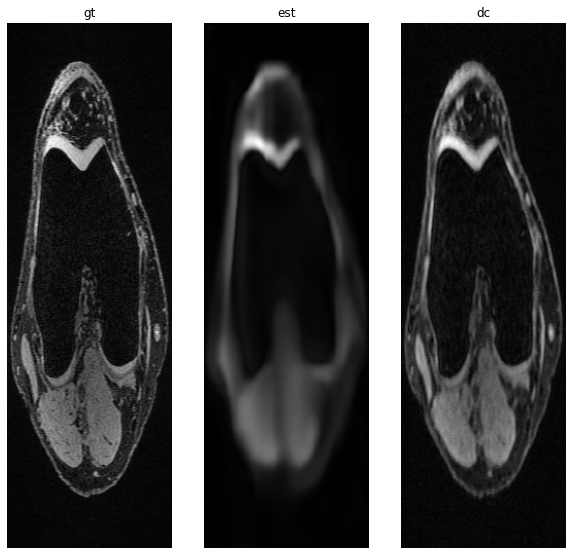

In [128]:
plot_list([img_gt, img_est, img_dc])